# Temperature Profile
This looks at the temperature profile, to see how it differs from the expected dry adiabat up to the LCL, followed by the moist adiabat.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting, annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, equivalent_potential_temp, potential_temp
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import interpolate
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2023-12-13 16:19:57,585 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [41]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 't_ref', 'ps', 'pk']  
# Load dataset
tau_lw_ref = 1
exp_dir = 'aquaplanet/temp_tendency/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", "k=1_5"]
n_exp = len(exp_names)
ds_base = []
albedo = []
tau_sw = []
tau_lw = []

use_time_start = 360*2
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_base += [ds_use.sel(time=slice(use_time_start, np.inf))]      # only keep after spin up
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
sigma_levels = np.asarray(namelist['vert_coordinate_nml']['bk']) 

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

Also get an equivalent dataset consisting of free troposphere rather than surface values: `ds_all_ft`.

In [42]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [43]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
# use_time_start = 0      # because little data

# Chose whether to only consider summer days for mean or all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH 
use_summer = False      # if true, will set ds will only contain summer months. Do this outside tropics

ds = []  # need both all and summer day dataset
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds_base[i]
        if use_summer:
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds += [ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))]
        pbar.update(1)
p_surface = float(ds[0].pfull[-1]) * 100

100%|██████████| 2/2 [00:00<00:00, 51.75it/s]


In [44]:
# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 45        # should be 40, but saving memory
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
ds = [ds[i].isel(lat=lat_use_ind).load() for i in range(n_exp)]
n_lat = ds[0].lat.shape[0]
n_pressure = ds[0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds[0].lat))     # latitude area weighting is just the cosine

## Hottest Day in Tropics

Here I take a single day, which is the hottest day in the tropics, and look at it in detail, to see why it deviates from the temperature profile we expect if it was convectively neutral.

In [45]:
single_day_kappa_ind_use = 0
max_surf_temp_ind = ds[single_day_kappa_ind_use].temp[-1].argmax(dim=['lat', 'lon_time'])
# max_surf_temp_ind = ds[single_day_kappa_ind_use].temp[-1].argmin(dim=['lat', 'lon_time'])
# max_surf_temp_ind['lat'] = 0
# max_surf_temp_ind['lon_time'] = 9421
ds_hot_day = ds[single_day_kappa_ind_use].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time']))
# ds_hot_day = ds[0].isel(lat=2, lon_time=38134)

In [57]:
p_all = ds_hot_day.pfull * 100
#p_all = p_hot_day
temp_ref_manual, temp_lcl, p_lcl = get_temp_ref(ds_hot_day.temp[-1], p_all[-1], ds_hot_day.sphum[-1], p_all)
temp_moist = moist_profile(float(temp_lcl), float(p_lcl), p_all[p_all<p_lcl])

# Compute using actual pressure values
# Sigma levels are at half pressure levels, so need to convolve to get pressure at full pressure levels.
p_hot_day = np.convolve(float(ds_hot_day.ps)*sigma_levels, np.ones(2)/2, 'valid')
temp_ref_manual2, temp_lcl2, p_lcl2 = get_temp_ref(ds_hot_day.temp[-1], p_hot_day[-1], ds_hot_day.sphum[-1], p_hot_day)
temp_moist2 = moist_profile(float(temp_lcl2), float(p_lcl2), p_hot_day[p_hot_day<p_lcl2])

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:152: UserWarning: Changing temp_start to a float
  warnings.warn('Changing temp_start to a float')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:155: UserWarning: Changing p_start to a float
  warnings.warn('Changing p_start to a float')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:158: UserWarning: Changing sphum_start to a float
  warnings.warn('Changing sphum_start to a float')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:164: UserWarning: Changing p_full to a numpy array
  warnings.warn('Changing p_full to a numpy array')


### Temperature Profile of a single day

Here we show that in the free troposphere, the simulated temperature (blue line) is lower than the reference temperature profile that convection acts to relax it to (orange solid line).

The dotted orange line is my attempt at computing the reference temperature profile offline, but it is slightly different. One reason is that the starting temperature of ascent is larger.

The green line shows the moist adiabat, and is only shown above the LCL. Again it differs from the temperature profile, that convection is relaxing it towards.

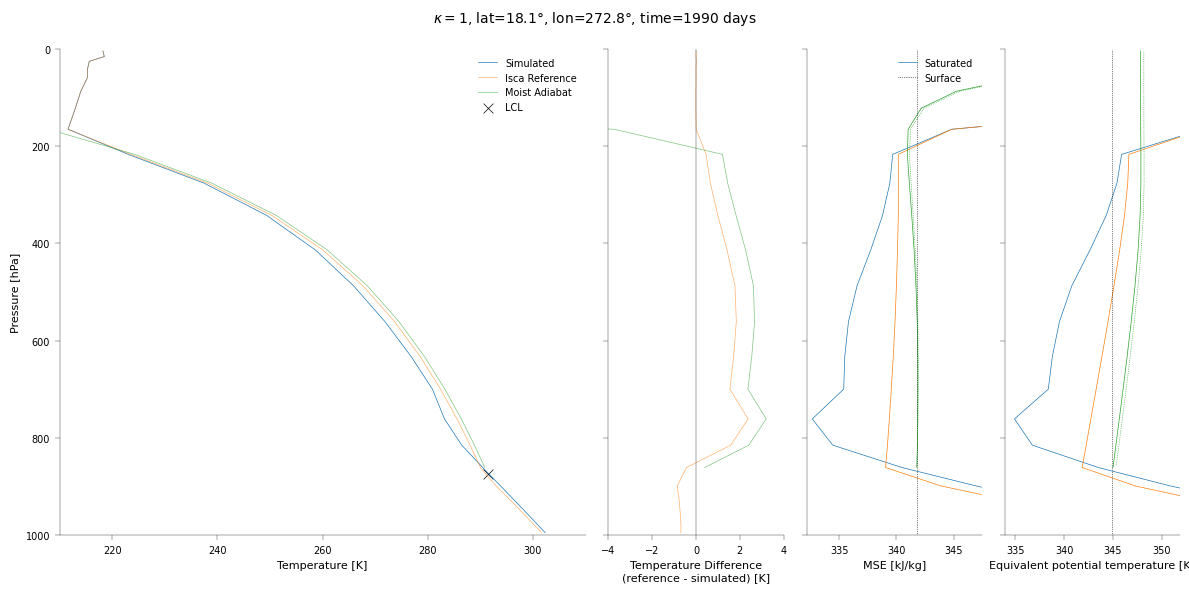

In [59]:
fig, ax = plt.subplots(1, 4, figsize=(12,6), gridspec_kw={'width_ratios': [3, 1, 1, 1]}, sharey=True)
ax[0].plot(ds_hot_day.temp, p_all/100, color=default_colors[0], label='Simulated')
ax[0].plot(ds_hot_day.t_ref, p_all/100, color=default_colors[1], alpha=0.6, label='Isca Reference')
ax[0].plot(temp_moist, p_all[p_all<p_lcl]/100, color=default_colors[2], alpha=0.6, label='Moist Adiabat')
ax[0].scatter(temp_lcl, p_lcl/100, color='k', marker='x', s=50, label='LCL')
ax[0].set_xlim(210, 310)
ax[0].legend()
ax[0].set_xlabel('Temperature [K]')

ax[1].plot(ds_hot_day.t_ref - ds_hot_day.temp, p_all/100, color=default_colors[1], alpha=0.6, label='Isca Reference')
ax[1].plot(temp_moist - ds_hot_day.temp[p_all<p_lcl], p_all[p_all<p_lcl]/100, color=default_colors[2], alpha=0.6, label='Moist Adiabat')
ax[1].vlines(0, 1000, 0, color='k', lw=ax_linewidth)
ax[1].set_xlim(-4,4)
ax[1].set_xlabel('Temperature Difference\n(reference - simulated) [K]')


xlims = [1000, 0]
xlims_p_ind_use = np.logical_and(p_all/100>300, p_all/100<900)
var = moist_static_energy(ds_hot_day.temp, sphum_sat(ds_hot_day.temp, p_all), ds_hot_day.height)
ax[2].plot(var, p_all/100, color=default_colors[0], label='Saturated')
xlims[0] = np.min([xlims[0], var[xlims_p_ind_use].min()])
xlims[1] = np.max([xlims[1], var[xlims_p_ind_use].max()])
var = moist_static_energy(ds_hot_day.t_ref, sphum_sat(ds_hot_day.t_ref, p_all), ds_hot_day.height)
ax[2].plot(var, p_all/100, color=default_colors[1])
xlims[0] = np.min([xlims[0], var[xlims_p_ind_use].min()])
xlims[1] = np.max([xlims[1], var[xlims_p_ind_use].max()])
var = moist_static_energy(temp_moist, sphum_sat(temp_moist, p_all[p_all<p_lcl]), ds_hot_day.height[p_all<p_lcl])
ax[2].plot(var, p_all[p_all<p_lcl]/100, color=default_colors[2])
xlims[0] = np.min([xlims[0], var[xlims_p_ind_use[p_all<p_lcl]].min()])
xlims[1] = np.max([xlims[1], var[xlims_p_ind_use[p_all<p_lcl]].max()])
var = moist_static_energy(ds_hot_day.temp[-1], ds_hot_day.sphum[-1], ds_hot_day.height[-1])
ax[2].vlines(var, 1000, 0, color='k', linestyle=':', label='Surface')
xlims[0] = np.min([xlims[0], var])
xlims[1] = np.max([xlims[1], var])
ax[2].set_xlim(xlims[0]-0.5, xlims[1]+0.5)
ax[2].set_xlabel('MSE [kJ/kg]')
ax[2].legend()

xlims = [1000, 0]
var = equivalent_potential_temp(ds_hot_day.temp, p_all)
ax[3].plot(var, p_all/100, color=default_colors[0])
xlims[0] = np.min([xlims[0], var[xlims_p_ind_use].min()])
xlims[1] = np.max([xlims[1], var[xlims_p_ind_use].max()])
var = equivalent_potential_temp(ds_hot_day.t_ref, p_all)
ax[3].plot(var, p_all/100, color=default_colors[1])
xlims[0] = np.min([xlims[0], var[xlims_p_ind_use].min()])
xlims[1] = np.max([xlims[1], var[xlims_p_ind_use].max()])
var = equivalent_potential_temp(temp_moist, p_all[p_all<p_lcl])
ax[3].plot(var, p_all[p_all<p_lcl]/100, color=default_colors[2])
xlims[0] = np.min([xlims[0], var[xlims_p_ind_use[p_all<p_lcl]].min()])
xlims[1] = np.max([xlims[1], var[xlims_p_ind_use[p_all<p_lcl]].max()])
# ax[3].plot(potential_temp(temp_moist, p_all[p_all<p_lcl]), p_all[p_all<p_lcl]/100, color=default_colors[2], linestyle=':')
var = equivalent_potential_temp(ds_hot_day.temp[-1], p_all[-1], ds_hot_day.sphum[-1])
ax[3].vlines(var, 1000, 0, color='k', linestyle=':')
xlims[0] = np.min([xlims[0], var])
xlims[1] = np.max([xlims[1], var])
ax[3].set_xlim(xlims[0]-1, xlims[1]+1)
ax[3].set_xlabel('Equivalent potential temperature [K]')

var = moist_static_energy(temp_moist2, sphum_sat(temp_moist2, p_hot_day[p_hot_day<p_lcl2]), ds_hot_day.height[p_hot_day<p_lcl2])
ax[2].plot(var, p_hot_day[p_hot_day<p_lcl2]/100, color=default_colors[2], linestyle=':')
var = equivalent_potential_temp(temp_moist2, p_hot_day[p_hot_day<p_lcl2])
ax[3].plot(var, p_hot_day[p_hot_day<p_lcl2]/100, color=default_colors[2], linestyle=':')


ax[0].invert_yaxis()
ax[0].set_ylim(1000, 0)
ax[0].set_ylabel('Pressure [hPa]')
fig.suptitle(f'$\kappa={tau_lw[single_day_kappa_ind_use]}$, lat={round(float(ds_hot_day.lat), 1)}$\degree$, '
             f'lon={round(float(ds_hot_day.lon), 1)}$\degree$, time={int(ds_hot_day.time+0.5)} days', fontsize=10)
plt.tight_layout()

## Changes with warming relative to mean

Below I show that changes in MSE and equivalent potential temperature are very similar.

In [44]:
# Need to choose quantile method, use 'temp' for comparison with land.
# quant_method = 'byrne'      # var_quant2 will be the x percentile of var (as in Byrne 2021)
quant_method = 'temp'       # var_quant2 will be the average of var conditioned on the days with x percentile of temperature

if quant_method == 'byrne':
    label_quant = 'Percentile, $x$'
elif quant_method == 'temp':
    label_quant = 'Temperature percentile, $x$'
else:
    raise ValueError('quant_method is not valid')

# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)

temp_mean = np.zeros((n_exp, n_lat))
sphum_mean = np.zeros((n_exp, n_lat))
mse_mean = np.zeros((n_exp, n_lat))
equiv_pot_temp_mean = np.zeros((n_exp, n_lat))

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = np.zeros((n_exp, n_lat, n_quant))
# specific humidity as function of specific humidity quantile (quant_method=byrne) or temp quantile (quant_method=temp)
sphum_quant2 = np.zeros((n_exp, n_lat, n_quant))
# mse as function of mse quantile (quant_method=byrne) or temp quantile (quant_method=temp)
mse_quant2 = np.zeros((n_exp, n_lat, n_quant))
# equivalent potential temperature as function of mse quantile (quant_method=byrne) or temp quantile (quant_method=temp)
equiv_pot_temp_quant2 = np.zeros((n_exp, n_lat, n_quant))

with tqdm(total=n_exp*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(pfull=np.inf, method='nearest')      # only consider surface
        temp_mean[i] = ds_use.temp.mean(dim='lon_time')
        sphum_mean[i] = ds_use.sphum.mean(dim='lon_time')
        mse_mean[i] = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height).mean(dim='lon_time')
        equiv_pot_temp_mean[i] = equivalent_potential_temp(ds_use.temp, p_surface, ds_use.sphum).mean(dim='lon_time')
    
        temp_quant2[i] = ds_use.temp.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
        mse_use = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)
        equiv_pot_temp_use = equivalent_potential_temp(ds_use.temp, p_surface, ds_use.sphum)
        if quant_method == 'byrne':
            sphum_quant2[i] = ds_use.sphum.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
            mse_quant2[i] = mse_use.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
            equiv_pot_temp_quant2[i] =  equiv_pot_temp_use.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
            pbar.update(n_quant*n_lat)
        elif quant_method == 'temp':
            for k in range(n_lat):
                for j, quant in enumerate(quant_plot):
                    use_ind = get_quant_ind(ds_use.temp[k], quant, 0.5, 0.5)
                    sphum_quant2[i, k, j] = ds_use.sphum[k, use_ind].mean()
                    mse_quant2[i, k, j] = mse_use[k, use_ind].mean()
                    equiv_pot_temp_quant2[i, k, j] = equiv_pot_temp_use[k, use_ind].mean()
                    pbar.update(1)

100%|██████████| 2772/2772 [00:22<00:00, 121.95it/s]


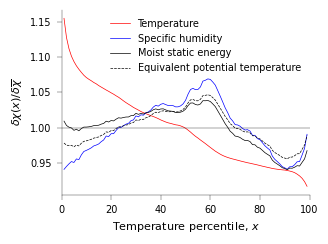

In [45]:
save_lambda_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
labels = ['Temperature','Specific humidity', 'Moist static energy', 'Equivalent potential temperature']
# Divide by the difference in the mean not by the difference in the median because from the above plot, the percentile p_x=50 for
# MSE does not have a corresponding temperature percentile, x.
delta_var_mean = [np.expand_dims(var[1] - var[0], axis=-1) for var in [temp_mean, sphum_mean, mse_mean, equiv_pot_temp_mean]]
colors_use = ['r', 'b', 'k', 'k']
for i, var in enumerate([temp_quant2, sphum_quant2, mse_quant2, equiv_pot_temp_quant2]):
    var_ratio = ((var[1]-var[0])/delta_var_mean[i])
    ax.plot(quant_plot, np.average(var_ratio, axis=0, weights=lat_weights), label=labels[i], color=colors_use[i], 
            linestyle='--' if i==3 else '-')
ax.hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax.legend(loc='upper right')
ax.set_xlabel(label_quant)
ax.set_ylabel('$\delta \chi(x)/\delta \overline{\chi}$')
# ax.set_ylim(0.85,1.15)
ax.set_xlim(0, 100)
if save_fig or save_lambda_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_equiv_pot_temp_{region.lower()}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)